In [1]:
from FairFront import FairFront
from DataLoader_FairFront import load_data
from DiscreteFairFront import *
import numpy as np
import cvxpy as cp
import dccp

import sys
import pandas as pd
import numpy as np

import random
import pickle
import time
from tqdm import tqdm
from time import localtime, strftime

In [2]:
seed_n = 42
random.seed(seed_n)
np.random.seed(seed_n)

In [3]:
# read in data using the DataLoader module
df = load_data(name='compas', perturbed= False)  
df

/Users/luxihe/Documents/GitHub/aleatoric_epistemic_discrimination/FairFront/DataLoader_FairFront.py:234: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'race'] = df['race'].apply(lambda x: 1 if x=='Caucasian' else 0)
/Users/luxihe/Documents/GitHub/aleatoric_epistemic_discrimination/FairFront/DataLoader_FairFront.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'sex'] = df['sex'].apply(lambda x: 1 if x=='Male' else 0)
/Users/luxihe/Documents/GitHub/aleatoric_epistemic_discrimination/FairFront/DataLoader_FairFront.py:245: FutureWa

,age,c_charge_degree,race,gender,priors_count,is_recid,length_of_stay,SY,stay_discrete,age_discrete
0,34,1,0,1,0,1,10,1,1,3
1,24,1,0,1,4,1,1,1,1,1
2,41,1,1,1,14,1,6,3,1,5
3,39,-1,1,0,0,0,2,2,1,4
4,27,1,1,1,0,0,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...
5273,30,-1,0,1,0,1,0,1,0,3
5274,20,1,0,1,0,0,0,0,0,1
5275,23,1,0,1,0,0,1,0,1,1
5276,23,1,0,1,0,0,1,0,1,1


In [20]:
# read in perturbed data using pickled dataset 
# df = pd.read_pickle("../data/COMPAS/COMPAS_perturbed_maj0.1_min0.1.pkl")
# df

### Approximate with discrete r.v.

In [4]:
used_columns = df[['age_discrete', 'c_charge_degree', 'gender', 'priors_count',
       'stay_discrete', 'race', 'SY'] ]
      
pmf_dict = {0:{}, 1:{}, 2:{}, 3:{}}

def get_type_count(row):
    sy = row['SY']
    key = (row['age_discrete'],row['c_charge_degree'],row['gender'],row['priors_count'], row['stay_discrete'], row['race'])
    if key not in pmf_dict[sy]:
        pmf_dict[sy].update({key: 1})
    else:
        pmf_dict[sy][key] =  pmf_dict[sy][key] + 1
    

for index, row in used_columns.iterrows():
    get_type_count(row)

for i in range(4):
    total_i = sum(pmf_dict[i].values())
    pmf_dict[i] = {key: value / total_i for key, value in pmf_dict[i].items()}


In [5]:
# output support as a list 
support_list = []
for i in range(4):
    support_list += list(pmf_dict[i].keys())

support_X = list(set(support_list)) # support of input features
calX = len(support_X) # support size of input features
calX


1640

In [6]:
def get_pmf(dictionary, x):
    '''
    if x is in dictionary pmf_dict[i], then use that value. If not, fill in 0
    '''
    if x in dictionary:
        return dictionary[x]
    else:
        return 0 

# transition matrix from (s,y) to x
T_SY_X  = np.vstack([[get_pmf(pmf_dict[0], x) for x in support_X], \
           [get_pmf(pmf_dict[1], x) for x in support_X], \
           [get_pmf(pmf_dict[2], x) for x in support_X], \
           [get_pmf(pmf_dict[3], x) for x in support_X]
            ])

T_SY_X.shape


(4, 1640)

#### Obtain transition matrix and conditional distribution

In [7]:
A = 2
C = 2
sensitive_s = 'race'
label_y = 'is_recid'
# get the mu_s,y values, encoded in matrix mu_SY
mu_SY = np.zeros((A, C))
mu_SY = np.zeros((2, 2))
for index, row in df.iterrows():
    s,y = int(row[sensitive_s]), int(row[label_y])
    mu_SY[s][y] = mu_SY[s][y] + 1
mu_SY = mu_SY/len(df)

map_ind_X = dict(zip(range(calX), support_X))
map_X_ind = dict(zip(support_X, range(calX)))

In [8]:
def g_emp(x):
    '''
    compute g function from the empirical distribution
    '''
    result_vector = []
    ind_x = map_X_ind[x]
    for s in range(A):
        for y in range(C):
            result_vector.append(T_SY_X[s*C + y, ind_x] * mu_SY[s][y])
    #normalize
    result_vector = result_vector/(sum(result_vector))
    return result_vector

In [9]:
distinf = {"T": T_SY_X, "map": map_ind_X, "mu_SY": mu_SY}

#### Generate FairFront

In [13]:
# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0

epsilon = []
opt_list = []
opt_discrete_list = []

for i in np.linspace(0,0.1,10):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    FairFront_value = FairFront(A, C, g_emp, sensitive_s = sensitive_s, label_y=label_y, InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    optimal_value,_,_ = FairFront_value.Algorithm()
    opt_list.append(optimal_value)

    # FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    # value = FairFront_discrete.FairFront()
    # opt_discrete_list.append(value)
    

    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("true_opt_list:", opt_list)

        

current i: 0.0
current iteration: 0
Time for this iteration: 1.867 mins

true_opt_list: [0.7619731135141423]
current i: 0.011111111111111112
current iteration: 0
Time for this iteration: 1.850 mins

true_opt_list: [0.7619731135141423, 0.768445932667334]
current i: 0.022222222222222223
current iteration: 0
Time for this iteration: 1.833 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601]
current i: 0.03333333333333333
current iteration: 0
Time for this iteration: 1.900 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359]
current i: 0.044444444444444446
current iteration: 0
Time for this iteration: 1.967 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.7704106332293201]
current i: 0.05555555555555556
current iteration: 0
Time for this iteration: 1.983 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.770410

In [18]:
# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0

for i in np.linspace(0.111,0.23,6):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    FairFront_value = FairFront(A, C, g_emp, sensitive_s = sensitive_s, label_y=label_y, InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    optimal_value,_,_ = FairFront_value.Algorithm()
    opt_list.append(optimal_value)

    # FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    # value = FairFront_discrete.FairFront()
    # opt_discrete_list.append(value)
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("true_opt_list:", opt_list)

        

current i: 0.111
current iteration: 0
Time for this iteration: 1.850 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.7704106332293201, 0.7707584731120786, 0.7710930044807173, 0.7713712139679151, 0.771504357891399, 0.7715043580005451, 0.7715043577268292]
current i: 0.1348
current iteration: 0
Time for this iteration: 1.917 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.7704106332293201, 0.7707584731120786, 0.7710930044807173, 0.7713712139679151, 0.771504357891399, 0.7715043580005451, 0.7715043577268292, 0.7715043577377221]
current i: 0.15860000000000002
current iteration: 0
Time for this iteration: 1.900 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.7704106332293201, 0.7707584731120786, 0.7710930044807173, 0.7713712139679151, 0.771504357891399, 0.7715043580005451, 0.7715043577268292, 0.7715043577377221, 0.7715043577379517

In [20]:
for i in [0.003703703703703704, 0.003703703703703704*2, 0.016666666666666666]:
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    FairFront_value = FairFront(A, C, g_emp, sensitive_s = sensitive_s, label_y=label_y, InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    optimal_value,_,_ = FairFront_value.Algorithm()
    opt_list.append(optimal_value)

    # FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    # value = FairFront_discrete.FairFront()
    # opt_discrete_list.append(value)
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("true_opt_list:", opt_list)

        

current i: 0.003703703703703704
current iteration: 0
Time for this iteration: 2.067 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.7704106332293201, 0.7707584731120786, 0.7710930044807173, 0.7713712139679151, 0.771504357891399, 0.7715043580005451, 0.7715043577268292, 0.7715043577377221, 0.7715043577379517, 0.7715043590454401, 0.771504359290871, 0.771504358006493, 0.7642010888457242]
current i: 0.007407407407407408
current iteration: 0
Time for this iteration: 2.250 mins

true_opt_list: [0.7619731135141423, 0.768445932667334, 0.7695894794508601, 0.7700446199650359, 0.7704106332293201, 0.7707584731120786, 0.7710930044807173, 0.7713712139679151, 0.771504357891399, 0.7715043580005451, 0.7715043577268292, 0.7715043577377221, 0.7715043577379517, 0.7715043590454401, 0.771504359290871, 0.771504358006493, 0.7642010888457242, 0.766429066188723]
current i: 0.016666666666666666
current iteration: 0
Time for this iteration: 2.233 mins

true_op

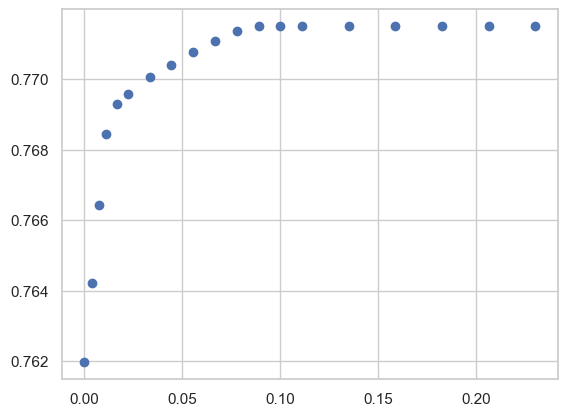

In [23]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
sns.set(style="whitegrid")

plt.plot(epsilon, opt_list, 'o')